In [45]:
# データ分析・操作用ライブラリ
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# NLP用ライブラリ
import MeCab,re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec

# スコア評価用ライブラリ
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support

# エラー表示の抑制
import warnings

In [2]:
# 表示関連
# DataFrameの列数設定
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

In [36]:
def tokenize(text):
    tokens = []
    tagger = MeCab.Tagger()
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in ['名詞'] :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [37]:
def MeanEmbeddingVectorizer(arr, model):
    mean_vectors = []
    for document in arr:
        tokens = tokenize(document)
        vectors = [model.get_vector(token) for token in tokens if token in model.vocab]
        if vectors:
            mean_vec = np.vstack(vectors).mean(axis=0)
            mean_vectors.append(mean_vec)
        else:
            mean_vectors.append(np.zeros(100))
        embedding = np.vstack(mean_vectors)        
    return embedding

In [4]:
# テキストデータの読み込み
wikiData = pd.read_csv("csv/train_cleaned.csv", encoding="utf-8")

# 読み込みデータの表示
wikiData.head()

,text,target
0,ドール・フード・カンパニー ドール・フード・カンパニー Dole Food Comp...,1
1,南ヶ丘牧場 株式会社 南ヶ丘牧場 みなみ じょう 栃木県 那須高原 本拠 酪...,1
2,岩瀬牧場 岩瀬牧場 ぼくじょう 日本 福島県 岩瀬 郡 鏡石町 牧場 鏡石...,1
3,くら ぎ GI Co Ltd 三重県 中心 農業 店舗 展開 会社 本...,1
4,ハッピーネモファーム 株式会社 ハッピーネモファーム 北海道 浦河 郡 浦河町 ...,1


In [5]:
# Numpy配列へ変換
X = wikiData.text.values
y = wikiData.target.values

In [38]:
# トレーニングデータ、テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# 分散表現の読み込み
import gensim.models.keyedvectors as word2vec_for_txt
model_dir = 'model/fastText.model.vec'
model = word2vec_for_txt.KeyedVectors.load_word2vec_format(model_dir, binary=False)

In [39]:
# 分散表現へ変換
X_train = MeanEmbeddingVectorizer(X_train, model)
X_test = MeanEmbeddingVectorizer(X_test, model)

In [42]:
# Light GBM
import lightgbm as lgb

clf = lgb.LGBMClassifier(objective='multiclass', num_class=33)
clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Training score：" + str(clf.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf.score(X_test, y_test)))

Training score：0.999890877346
Cross-Validation score：0.699515856083
Test score：0.692274116107


D:\Program\Anaconda3\envs\sklearn1.9.1\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


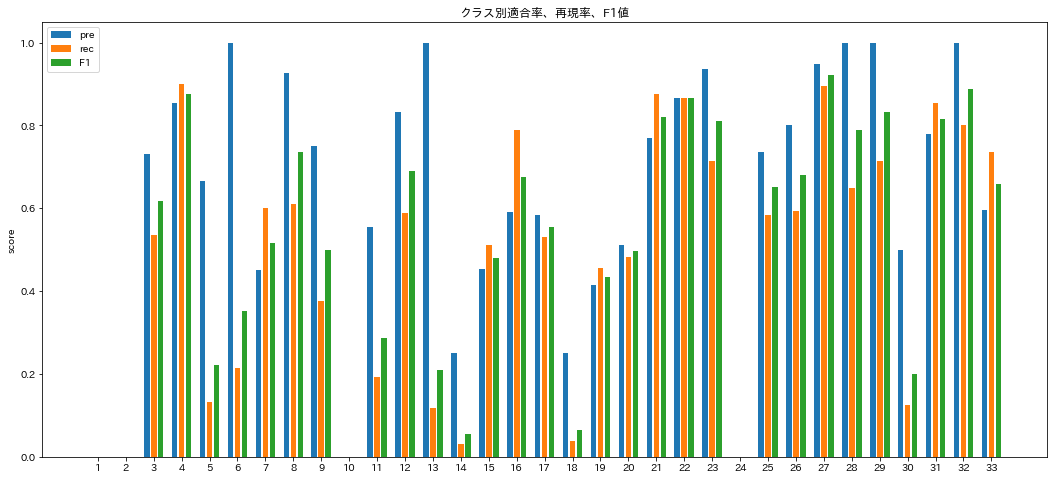

In [46]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)
wiki_gpby = wikiData.groupby('target').count()
y = wiki_gpby['text'].values
x =wiki_gpby.index.values

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()